# Sentiment analysis - Text classification for reviews of Amazon Grocery and Gourmet 




### Import the review data, pre-process, explore

In [1]:
import pandas as pd

# Read the Amazon Grocery_and_Gourmet review data into dataframe
# Source : http://jmcauley.ucsd.edu/data/amazon/
df = pd.read_json('Grocery_and_Gourmet_Food_5.json', lines=True)

# shuffle df rows
df = df.sample(frac=1, random_state=17).reset_index(drop=True)

df.head()


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000FDMMVW,"[2, 2]",5,I bought each of the Ryvita varieties Amazon o...,"02 21, 2007",A2OL5WLCNZVD9K,nonpareil,Ryvita is even better with fruit in it.,1172016000
1,B001EQ5IN8,"[0, 0]",5,"I love this tea, it smells and tastes so great...","06 15, 2014",A20WEGZGLW6U9F,yakoanders,The best tea,1402790400
2,B002C58RME,"[1, 2]",4,To say 'this is bad coffee' or 'this is good c...,"04 28, 2011",A2YKWYC3WQJX5J,"Shannon Lastowski ""Queen of Caffeine""",Not the best but worth the price,1303948800
3,B00DBSGJ4E,"[0, 0]",3,At least the 3rd ingredient is APPLE PUREE CON...,"11 21, 2013",A1I6U5AQAT3ZG9,"E. B. MULLIGAN ""Bronwyn""",the first two ingredients are CORN SYRUP & SUGAR,1384992000
4,B0049TZA26,"[0, 0]",4,"great taste, great quality, a bit pricey..... ...","04 9, 2013",A3KJO30ZT23J0N,"tooth fairy ""tooth fairy""",kirkland garlic,1365465600


In [2]:
df = df.drop(df[df['reviewText']==''].index)    # drop rows that has empty reviewText
cols = ['overall', 'reviewText', 'reviewTime', 'reviewerID', 'summary']
df = df[cols]  # drop columns 'asin', 'helpful', 'reviewerName'

print('Size of df : ', df.shape)

# Check percentage of each rating group in data
df['overall'].hist(bins=5)

print('\nCounts of each score group in data : \n{}'.format(df['overall'].value_counts()))
print('\nPercentage of each score group in data : \n{}'.format(round(df['overall'].value_counts()*100/len(df), 3)))

df.head()

Size of df :  (151232, 5)

Counts of each score group in data : 
5    87436
4    32593
3    17512
2     7916
1     5775
Name: overall, dtype: int64

Percentage of each score group in data : 
5    57.816
4    21.552
3    11.580
2     5.234
1     3.819
Name: overall, dtype: float64


,overall,reviewText,reviewTime,reviewerID,summary
0,5,I bought each of the Ryvita varieties Amazon o...,"02 21, 2007",A2OL5WLCNZVD9K,Ryvita is even better with fruit in it.
1,5,"I love this tea, it smells and tastes so great...","06 15, 2014",A20WEGZGLW6U9F,The best tea
2,4,To say 'this is bad coffee' or 'this is good c...,"04 28, 2011",A2YKWYC3WQJX5J,Not the best but worth the price
3,3,At least the 3rd ingredient is APPLE PUREE CON...,"11 21, 2013",A1I6U5AQAT3ZG9,the first two ingredients are CORN SYRUP & SUGAR
4,4,"great taste, great quality, a bit pricey..... ...","04 9, 2013",A3KJO30ZT23J0N,kirkland garlic


## Define binary target classes

1    120029
0     13691
Name: Positively Rated, dtype: int64

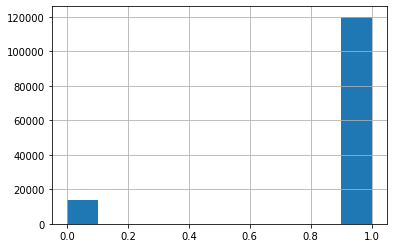

In [3]:
import numpy as np

# Remove any 'neutral' ratings equal to 3
df = df[df['overall'] != 3]

# Encode 4s and 5s as 1 (rated positively)
# Encode 1s and 2s as 0 (rated poorly)
df['Positively Rated'] = np.where(df['overall'] > 3, 1, 0)

# Re-index df
df.index = range(len(df))

# df.head(10)

df['Positively Rated'].hist()
df['Positively Rated'].value_counts()

## Split data into test-train stratified portions 

In [4]:
# Keep test set for final testing of selected model (10%)
#
# Training set is used for fitting models, hyperparamter search, x-validation, model selection etc.  
#
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(df['reviewText'], 
                                                    df['Positively Rated'], 
                                                    test_size=0.1,
                                                    stratify = df['Positively Rated'],
                                                    random_state=17)


## Text cleaning and pre-processing

### Punctuation and special characters removal

In [31]:
import re

# function for removing punctuations and special characters

def cleanpunc(text): 

    cleaned = re.sub(r'[?|!|\'|"|#|&]',r'',text)
    cleaned = re.sub(r'[.|,|;|)|(|\|/|-]',r' ',cleaned)
    cleaned = re.sub(r'[0-9]',r'',cleaned)

    return  cleaned 


In [ ]:
# Remove punctuation and special characters from reviewText and create a new column for the cleanedText

df['cleanedText'] = df['reviewText'].apply(lambda x : cleanpunc(x))


In [ ]:
df.head()

### Lemmatization and POS tagging

In [23]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Function for lemmatization and POS tagging

def lemmatize_pos(text, func):
    doc = nlp(text)
      
    if(func == 'lemma'):
        lemma = " ".join([token.lemma_ for token in doc])
        return lemma
    if(func == 'pos'):
        pos = [token.pos_ for token in doc]
        return pos


In [ ]:
# Put lemmatized and POS-tagged text in new columns

df.loc[:, 'lemma'] = df['reviewText'].apply(lambda x : lemmatize_pos(x, 'lemma'))
df.loc[:, 'pos'] = df['reviewText'].apply(lambda x : lemmatize_pos(x, 'pos'))

df.head()

## Functions for model evaluation

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Function for printing MEAN ACCURACY and ROC_AUC_SCORE
#
def Score_Model(x_test, y_test, model):
    ## Print mean accuracy
    print('Mean accuracy : {:.3f}'.format(model.score(x_test, y_test)) )
    
    prediction_prob = model.predict_proba(x_test)

    ## Print ROC-AUC score
    print('ROC-AUC score : {:.3f}'.format(roc_auc_score(y_test, prediction_prob[:,1])) )
    
    
def Print_ConfMatrix(x_test, y_test, model):
    
    prediction = model.predict(x_test)
    
    ## generate and print confusion matrix
    #
    cm = confusion_matrix(y_test, prediction)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["0","1"], yticklabels=["0","1"])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

In [ ]:
# test = df[0:20000]
len(df)*90/100*80/100


## Multinomial Naive Bayes classifier (un-lemmatized text)

In [5]:
from sklearn.model_selection import train_test_split

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2,
                                                  random_state=7)

X_train.head()

42972    I haven't found a use for all the flavors, but...
47075    Convenience is of course the reason I buy Tast...
44345    This is one of better tasting beef jerkys I've...
16804    This salt may be light, but it is seasoning wo...
10448    Some of the bags don't pop well.  Some don't e...
Name: reviewText, dtype: object

### Remove punctuation, symbols and numbers from text

In [42]:
# Remove punctuation, special characters and numbers from X_train and X_val

X_train_clean = X_train.apply(lambda x : cleanpunc(x))    
X_val_clean = X_val.apply(lambda x : cleanpunc(x))    

#### Hyperparameter search with cross validation

In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

from sklearn.model_selection import GridSearchCV  # TimeSeriesSplit,

from pprint import pprint
from time import time

In [51]:
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

parameters = {
    'vect__min_df': (5, 10, 15, 20),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2), (1,3)),  # unigrams or bigrams or trigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    # 'clf__max_iter': (20,),
    'clf__alpha': (0.001, 0.01, 0.1, 0.5, 1, 2),
    # 'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}


if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, cv=7, n_jobs=4, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train_clean, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
# parameters = {"alpha":  np.array( [1e-3, 1e-2, 0.1, 0.5, 1, 2])}
        
# NB_cv = make_pipeline(StandardScaler(), 
#                     GridSearchCV(('vect', CountVectorizer(ngram_range=(1,3), min_df = 10),
#                                   naive_bayes.MultinomialNB(),
#                                  param_grid=parameters,
#                                  cv=7,
#                                  refit=True))

# NB_cv.fit(X_train, y_train)
# NB_cv.predict()


# n_folds = 7
# cv_folds = TimeSeriesSplit(n_splits=n_folds).split(X_train)


# model = MultinomialNB()
# gsearch_cv = GridSearchCV(estimator=model, param_grid=parameters, cv=cv_folds, scoring='f1')

# gsearch_cv.fit(X_train, y_train)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (0.001, 0.01, 0.1, 0.5, 1, 2),
 'vect__min_df': (5, 10, 15, 20),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 7 folds for each of 72 candidates, totalling 504 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 21.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 494.6min
[Parallel(n_jobs=4)]: Done 504 out of 504 | elapsed: 501.9min finished


done in 30158.616s

Best score: 0.945
Best parameters set:
	clf__alpha: 0.1
	vect__min_df: 10
	vect__ngram_range: (1, 3)


In [52]:
MNB_model = grid_search.best_estimator_

#predict_MNB = MNB_model.predict(X_val)

Mean accuracy : 0.942
ROC-AUC score : 0.970


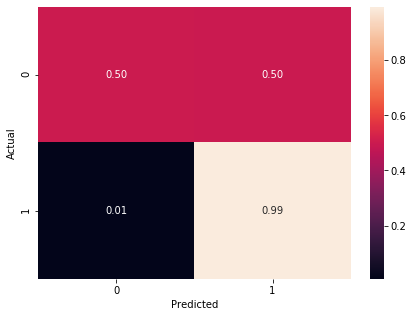

In [53]:
Score_Model(X_val, y_val, MNB_model)

Print_ConfMatrix(X_val, y_val, MNB_model)

In [54]:
len(MNB_model.named_steps.vect.get_feature_names())

178295

## Multinomial Naive Bayes classifier (lemmatized text)

In [55]:
X_lemma = X_train_clean.apply(lambda x : lemmatize_pos(x, 'lemma'))  # Lemmatize cleaned text



In [56]:
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, cv=7, n_jobs=4, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_lemma, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (0.001, 0.01, 0.1, 0.5, 1, 2),
 'vect__min_df': (5, 10, 15, 20),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 7 folds for each of 72 candidates, totalling 504 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 20.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 117.7min
[Parallel(n_jobs=4)]: Done 504 out of 504 | elapsed: 124.5min finished


done in 7511.587s

Best score: 0.944
Best parameters set:
	clf__alpha: 0.1
	vect__min_df: 15
	vect__ngram_range: (1, 3)


In [57]:
# X_val_clean = X_val.apply(lambda x : cleanpunc(x))    # Remove punctuation and special characters 
X_val_lemma = X_val_clean.apply(lambda x : lemmatize_pos(x, 'lemma'))  # Lemmatize cleaned text


Mean accuracy : 0.945
ROC-AUC score : 0.971


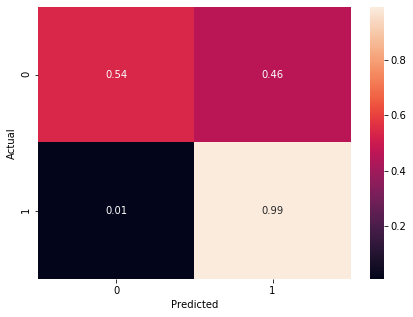

In [58]:
MNB_lemma_model = grid_search.best_estimator_

Score_Model(X_val_lemma, y_val, MNB_lemma_model)
Print_ConfMatrix(X_val_lemma, y_val, MNB_lemma_model)

In [60]:
len(MNB_lemma_model.named_steps.vect.get_feature_names())

# MNB_lemma_model.named_steps.vect.get_feature_names()

116955

## SVM classifier (lemmatized text)

In [ ]:
from sklearn.svm import SVC

pipeline_svm = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC()),
])

parameters = {
    'vect__min_df': (5, 10, 15),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 2), (1,3)),  # unigrams or bigrams or trigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    # 'clf__max_iter': (20,),
    'clf__C': (0.01, 0.1, 0.5, 1),
    'clf__kernel':("linear")
    # 'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}
